# Shifted Beta-Geometric Modeling with Cohorts

In this notebook we replicate the main results and figures from ["How to Project Customer Retention"](https://faculty.wharton.upenn.edu/wp-content/uploads/2012/04/Fader_hardie_jim_07.pdf) by Hardie & Fader (2007), which introduces the Shifted Beta-Geometric (sBG) model for customer behavior in a discrete contractual setting. It is ideal for business cases involving recurring subscriptions and has the following assumptions:
* Customer cancellation probabilities are Beta-distributed with hyperparameters `alpha` and `beta`.
* Retention rates change over time due to customer heterogeneity.
* All customers in a given cohort began their contract in the same time period.

The last assumption in particular is an ideal application for hierarchical Bayesian modeling.

# Tutorial Notebook Outstanding Tasks
- [ ] Merge Mean/Polarization index plotting PR
- [ ] Rename sBG data
- [ ] Merge Static Covariate PR
- [ ] Fit regular/highend data to both a cohort and covariate model to replicate research results
- [ ] Synthesize time cohort model with covariates to showcase conventional cohort EDA, additional predictive methods, and mean/polar plotting

In [1]:
import pytensor

#set flag to hotfix open c++ errors
pytensor.config.cxx = '/usr/bin/clang++'

In [2]:
import arviz as az
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import xarray as xr

from pymc_marketing import clv
import pymc as pm
from pymc_extras.prior import Prior

# Plotting configuration
az.style.use("arviz-darkgrid")
plt.rcParams["figure.figsize"] = [12, 7]
plt.rcParams["figure.dpi"] = 100
plt.rcParams["figure.facecolor"] = "white"

%load_ext autoreload
%autoreload 2
%config InlineBackend.figure_format = "retina"

OMP: Info #276: omp_set_nested routine deprecated, please use omp_set_max_active_levels instead.


# Load Data and EDA
Adapt plots from sBG-Individual notebook here.

In [5]:
# TODO: Need full dataset to T=13!
dataset = pd.read_csv("https://raw.githubusercontent.com/pymc-labs/pymc-marketing/refs/heads/main/data/sbg_reg_hi_cohorts.csv")
dataset.describe()

,customer_id,recency,T
count,2000.000000,2000.000000,2000.0
mean,1000.500000,4.508000,8.0
std,577.494589,2.981842,0.0
min,1.000000,1.000000,8.0
25%,500.750000,1.750000,8.0
50%,1000.500000,4.000000,8.0
75%,1500.250000,8.000000,8.0
max,2000.000000,8.000000,8.0


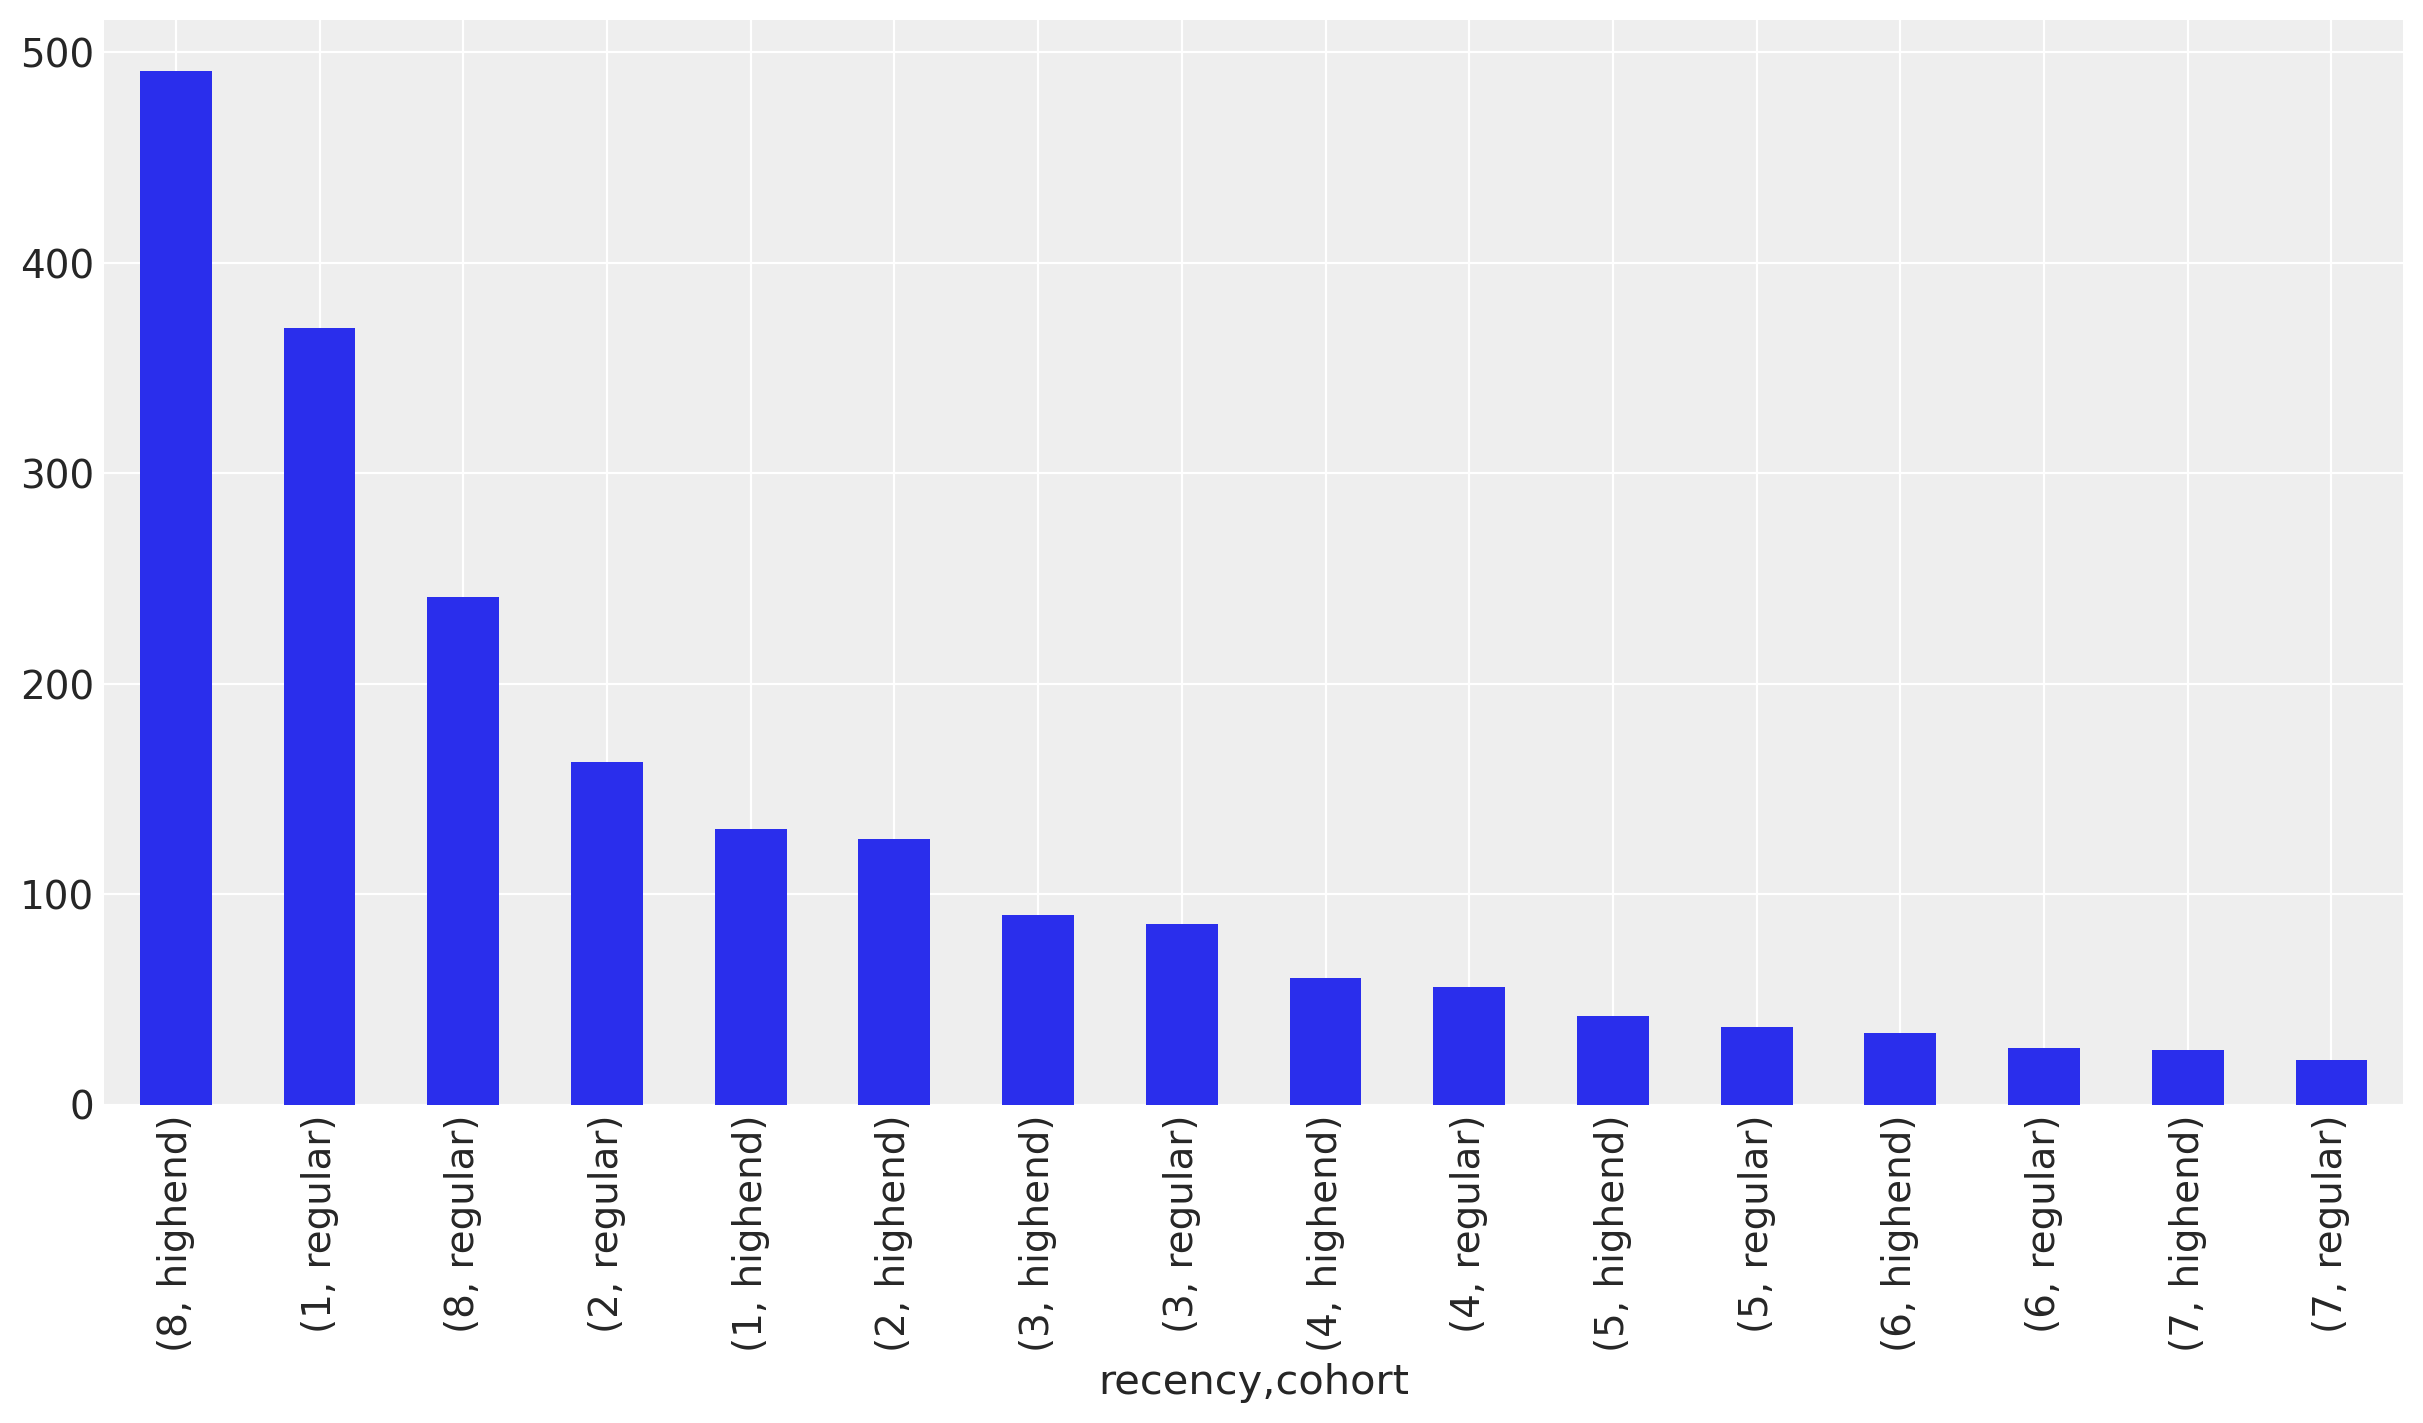

In [6]:
# Add a barplot of raw data here
dataset[["recency", "cohort"]].value_counts().plot(kind='bar');
# Add aggregation code to re-create data from the research paper in the next cell
# move imported dataframe generation code for all datasets into scripts/generate_data/

In [7]:
# Data from research paper
df = pd.DataFrame(
    {
        "regular": [
            100.0,
            63.1,
            46.8,
            38.2,
            32.6,
            28.9,
            26.2,
            24.1,
            22.3,
            20.7,
            19.4,
            18.3,
            17.3,
        ],
        "highend": [
            100.0,
            86.9,
            74.3,
            65.3,
            59.3,
            55.1,
            51.7,
            49.1,
            46.8,
            44.5,
            42.7,
            40.9,
            39.4,
        ],
    }
)
df

,regular,highend
0,100.0,100.0
1,63.1,86.9
2,46.8,74.3
3,38.2,65.3
4,32.6,59.3
5,28.9,55.1
6,26.2,51.7
7,24.1,49.1
8,22.3,46.8
9,20.7,44.5


In [ ]:
# Add code here to format CSV data into `df`. Could be worth adding as a utility function.

In [8]:
# Add code here to transform `df` back into CSV data. Will be added to scripts folder in notebook PR.

## Model Fitting

In [9]:
sbg = clv.ShiftedBetaGeoModel(
    data=dataset,
    model_config = {
        "alpha": Prior("HalfFlat",dims="cohort"),
        "beta": Prior("HalfFlat",dims="cohort")
    }
)
sbg.build_model()
sbg.fit(fit_method='map')
sbg.fit_summary()

Output()

alpha[highend]    0.668
alpha[regular]    0.704
beta[highend]     3.806
beta[regular]     1.182
Name: value, dtype: float64

#### Differential Evolution Metropolis
NUTS defaults to a compound sampler since this is a discrete sampling distribution. It still works great for a dataset of this size, but with large numbers of customers and cohorts, [`DEMetropolisZ`](https://www.pymc.io/projects/docs/en/v5.6.1/api/generated/pymc.DEMetropolisZ.html) may be more performant.

In [10]:
sbg = clv.ShiftedBetaGeoModel(
    data=dataset,
)
sbg.build_model()
sbg.fit(fit_method='demz',tune=3000, draws=3000) #'demz' needs a lot of tunes/draws
sbg.thin_fit_result(keep_every=2)
sbg.fit_summary(var_names=["alpha","beta"])

Multiprocess sampling (4 chains in 4 jobs)
DEMetropolisZ: [phi, kappa]


Output()

Sampling 4 chains for 3_000 tune and 3_000 draw iterations (12_000 + 12_000 draws total) took 4 seconds.


,mean,sd,hdi_3%,hdi_97%,mcse_mean,mcse_sd,ess_bulk,ess_tail,r_hat
alpha[highend],0.674,0.107,0.493,0.874,0.004,0.003,911.0,1317.0,1.0
alpha[regular],0.700,0.066,0.577,0.819,0.002,0.001,944.0,943.0,1.0
beta[highend],3.842,0.827,2.500,5.355,0.028,0.023,873.0,1205.0,1.0
beta[regular],1.172,0.155,0.912,1.467,0.005,0.003,1002.0,1324.0,1.0


## Contrasting posterior inferences with the repo MLE estimates

The sBG model has 2 population parameters of interest: `alpha` and `beta`. 
These parameters define the population distribution of the latent churn rate distribution `theta`. 
The larger the values of `alpha` and `beta`, the more homogenous the churn rates across different customers. 

The ratio of `alpha` to `beta` tells us the expected churn rates. If `alpha/beta == 0.1`, we expect the average customer to have a `0.1` probability of churning between each time period.

The model fitting agrees with the Maximum Likelihood estimates described in the original paper.
In addition, MCMC sampling, gives us useful information about the uncertainty of the fits.

array([[<Axes: title={'center': 'alpha'}>,
        <Axes: title={'center': 'alpha'}>],
       [<Axes: title={'center': 'beta'}>,
        <Axes: title={'center': 'beta'}>]], dtype=object)

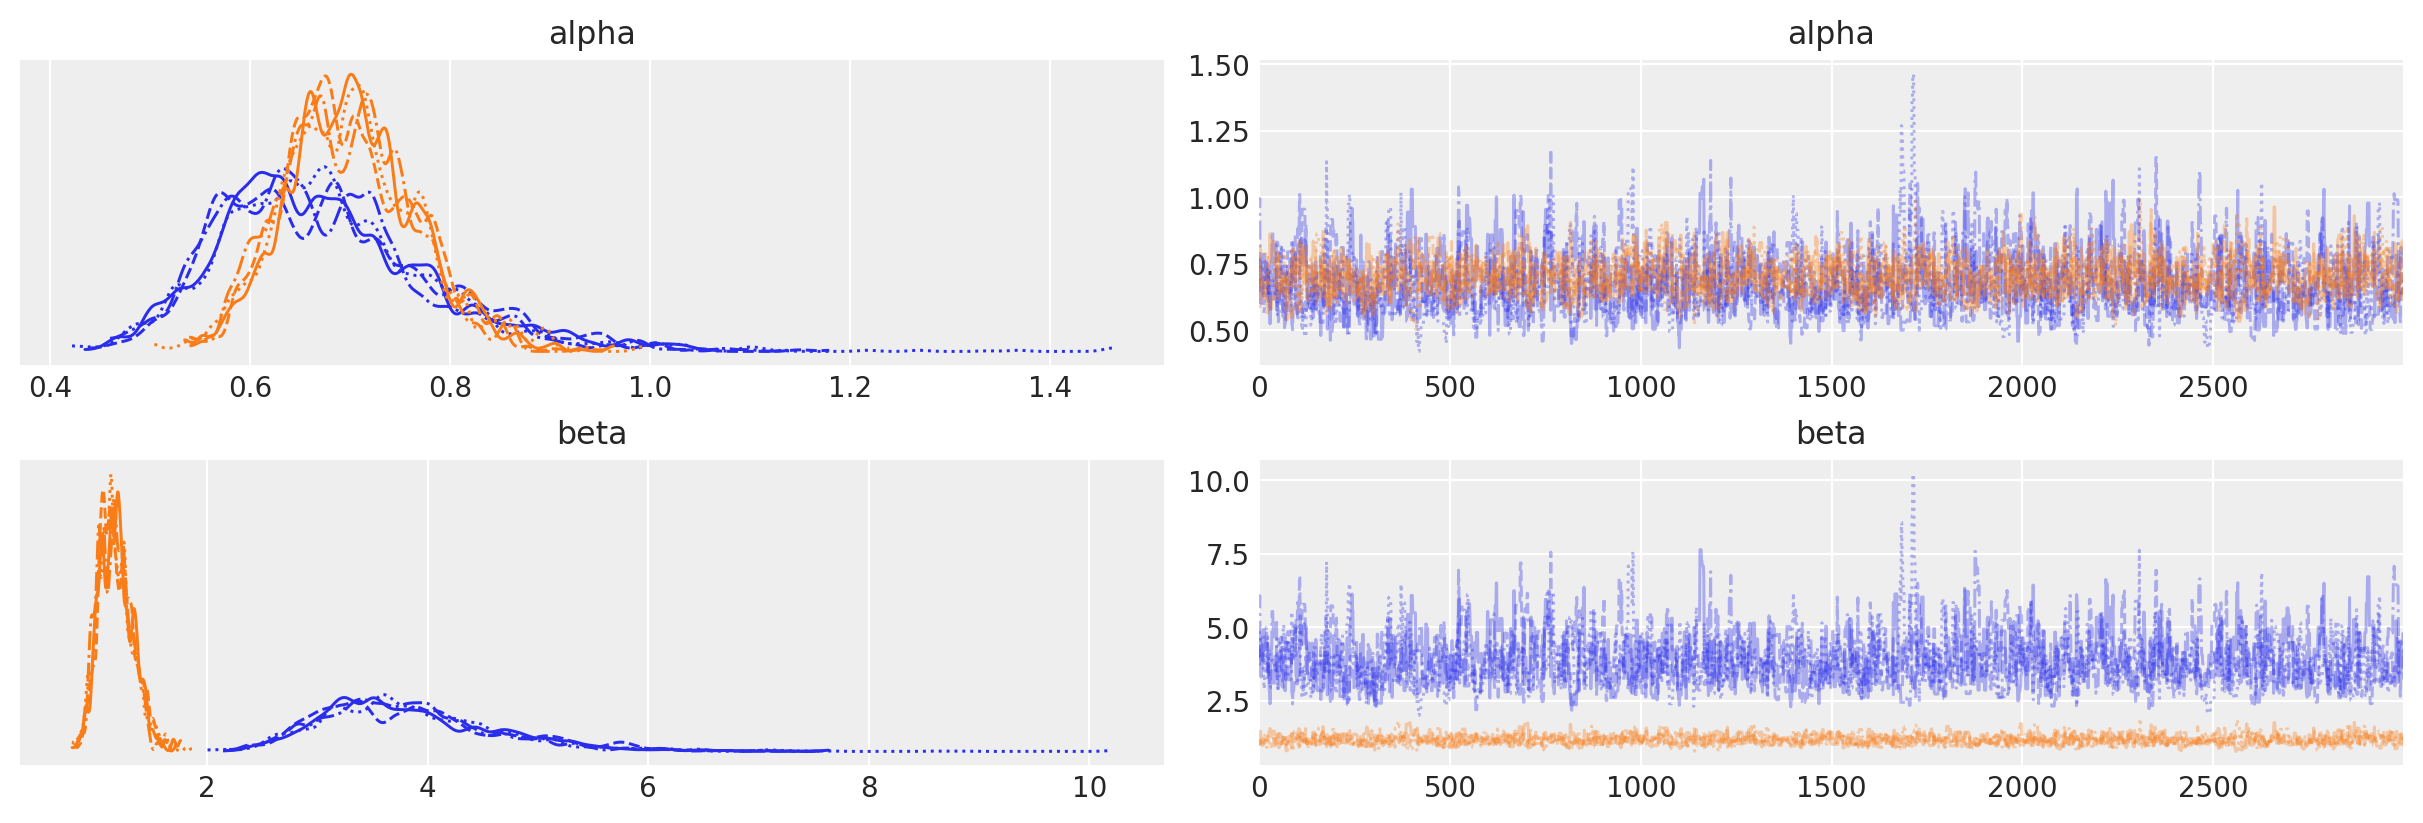

In [22]:

az.plot_trace(sbg.idata,var_names=["alpha","beta"])

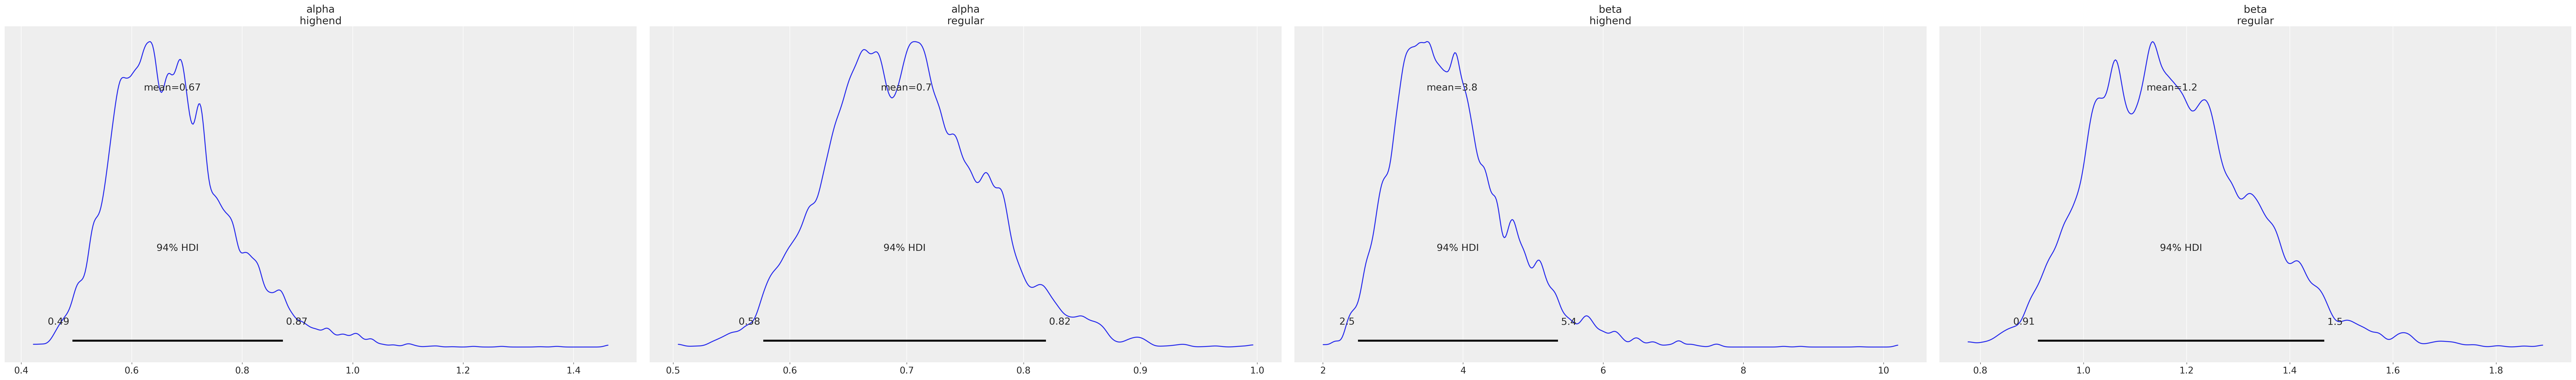

In [42]:
# ask AI to overlay MLE estimates here
# MLE estimates from the paper
ref_val = {
    "highend": [0.668, 3.806],
    "regular": [0.704, 1.182],
}
# Map cohort-wise [alpha, beta] refs to ArviZ variable labels
ref_val_map = {}
for cohort, (a_ref, b_ref) in ref_val.items():
    ref_val_map[f"alpha\n{cohort}"] = a_ref
    ref_val_map[f"beta\n{cohort}"]  = b_ref
   
az.plot_posterior(
    sbg.idata,
    var_names=["alpha", "beta"],
    ref_val=ref_val_map,
);

**Below plotting code cells were lifted directly from sBG-Individual notebook and require adaptation:**

In [29]:
# obs = df["highend"]/100

# plt.plot(survive_pred,color="b", label="predicted")
# plt.plot(obs,color="k", label="observed")
# plt.ylabel("Survival Rate")
# plt.legend()
# plt.title("High-End Customers MAP")

# plt.plot(reg_retention_cohort[:8],color="b", label="predicted")
# plt.plot(retention_rate_regular_obs[:8],color="k", label="observed")
# plt.ylabel("Retention Rate")
# plt.legend()
# plt.title("Regular Customers MCMC Estimated with Cohorts")

In [30]:
# az.plot_hdi(
#     weeks_,
#     hi_retention.mean("customer_id"),
#     hdi_prob=0.95,
#     color="C0",
#     fill_kwargs={"label": "high end"},
# )
# az.plot_hdi(
#     weeks_,
#     lo_retention.mean("customer_id"),
#     hdi_prob=0.95,
#     color="C1",
#     fill_kwargs={"label": "regular"},
# )

# plt.plot(weeks_, retention_rate_highend_obs, color="k", label="observed")
# plt.plot(weeks_, retention_rate_regular_obs, color="k")

# plt.axvline(7, ls="--", color="k")
# plt.ylim([0.5, 1.05])
# plt.ylabel("Retention Rate")
# plt.legend()
# plt.title("Figure 5");

# Predictive Methods
Retention Rate

In [27]:
# filter dataset to only active customers
pred_data=dataset.query("recency==T")

# predict retention rate and convert to dataframe for downstream processing
pred_cohort_retention = sbg.expected_retention_rate(pred_data,future_t=0).mean(("chain","draw"))
pred_cohort_retention.to_dataframe(name="retention").reset_index()

,cohort,customer_id,retention
0,highend,510,0.941823
1,highend,511,0.941823
2,highend,512,0.941823
3,highend,513,0.941823
4,highend,514,0.941823
...,...,...,...
727,regular,1996,0.921271
728,regular,1997,0.921271
729,regular,1998,0.921271
730,regular,1999,0.921271


Below cell is a WIP for plotting a time period trend for model evaluation for Probability Alive.

In [32]:
max_T = 12
cohort_names = np.array(["regular","highend"])
cohorts_covar = np.array([0,1])
T_rng = np.arange(1,max_T+1,1)


pred_data = pd.DataFrame(
    {
        "customer_id": np.arange(1,1+max_T*2,1),
        "T": np.repeat(T_rng,len(cohort_names)),
        "cohort": np.tile(cohort_names,max_T),
        "covar_cohort": np.tile(cohorts_covar,max_T),
    }
)

# retention rate is estimated from T-1 time periods, reducing array length by 1
retention_array = pred_data.query("T <=12").copy()

sbg.expected_probability_alive(
            data=retention_array,
            future_t=0,
        )

# expected_purchases_over_time = xr.concat(
#     objs=[
#         sbg.expected_retention_rate(
#             data=time_data,
#             future_t=0,
#         )
#         for t in range(time_periods)
#     ],
#     dim="t",
# ).transpose(..., "t")

# unique_cohorts = np.unique(expected_purchases_over_time.coords["cohort"].values)

# for cohort in unique_cohorts:
#     print(expected_purchases_over_time.sel(cohort=cohort).mean("t"))

The history saving thread hit an unexpected error (OperationalError('attempt to write a readonly database')).History will not be written to the database.


<xarray.DataArray (chain: 4, draw: 3000, cohort: 24)> Size: 2MB
array([[[0.60316848, 0.85938496, 0.45283335, ..., 0.40546541,
         0.1654545 , 0.3879019 ],
        [0.60316848, 0.85938496, 0.45283335, ..., 0.40546541,
         0.1654545 , 0.3879019 ],
        [0.60316848, 0.85938496, 0.45283335, ..., 0.40546541,
         0.1654545 , 0.3879019 ],
        ...,
        [0.6418052 , 0.84901974, 0.48890256, ..., 0.36934075,
         0.17654478, 0.35140334],
        [0.62491102, 0.85915101, 0.47297984, ..., 0.38720888,
         0.17187152, 0.36885885],
        [0.62491102, 0.85915101, 0.47297984, ..., 0.38720888,
         0.17187152, 0.36885885]],

       [[0.61345728, 0.86294481, 0.4600124 , ..., 0.3960535 ,
         0.16234013, 0.37763548],
        [0.60613999, 0.85356649, 0.44948174, ..., 0.40706599,
         0.15041931, 0.39021212],
        [0.59624798, 0.84727159, 0.4437931 , ..., 0.39065049,
         0.15638569, 0.37376428],
...
        [0.62330329, 0.83710444, 0.47552627, ..., 0.38085396,
         0.18267349, 0.36456222],
        [0.62330329, 0.83710444, 0.47552627, ..., 0.38085396,
         0.18267349, 0.36456222],
        [0.62330329, 0.83710444, 0.47552627, ..., 0.38085396,
         0.18267349, 0.36456222]],

       [[0.63910068, 0.85925874, 0.48809845, ..., 0.36188854,
         0.18092322, 0.34239595],
        [0.63790457, 0.85925027, 0.48844487, ..., 0.35743277,
         0.18486839, 0.33774289],
        [0.63512053, 0.84949522, 0.49257665, ..., 0.38640876,
         0.20365021, 0.36911938],
        ...,
        [0.59605595, 0.842845  , 0.44430782, ..., 0.38803129,
         0.15809636, 0.37147738],
        [0.61683709, 0.85840348, 0.47112547, ..., 0.40307073,
         0.18507704, 0.38551343],
        [0.61683709, 0.85840348, 0.47112547, ..., 0.40307073,
         0.18507704, 0.38551343]]], shape=(4, 3000, 24))
Coordinates:
  * chain        (chain) int64 32B 0 1 2 3
  * draw         (draw) int64 24kB 0 1 2 3 4 5 ... 2994 2995 2996 2997 2998 2999
  * cohort       (cohort) object 192B 'regular' 'highend' ... 'highend'
    customer_id  (cohort) int64 192B 1 2 3 4 5 6 7 8 ... 17 18 19 20 21 22 23 24

Figures 4 and 5 show the predicted average churn and retention trends for the two groups.
We can see that predictions nicely match the observed data (black line), even when extrapolating into the time periods that were held-out when fitting the model.

The plots also highlight an interesting implication from the model: 
the retention rates are expected to increase over time, as the more precarious customers gradually drop out. This is a direct consequence of modelling individual churn rates as being fixed over time.

These additional predictive methods are described in https://faculty.wharton.upenn.edu/wp-content/uploads/2012/04/Fader_hardie_contractual_mksc_10.pdf

*Expected Residual Lifetimes*

### Expected Retention Elasticity

### Simulate Data from Follow-Up Paper
Adapt below code to create time-period cohorts with highend & regular covariate customers mixed into each.

In [33]:
import numpy as np
import pandas as pd

# Cohort table from the markdown (empty cells omitted)
# only need the params for unit testing
# alpha 3.80, beta = 15.20
cohort_counts = {
    2001: {2001: 10000, 2002: 8000, 2003: 6480, 2004: 5307, 2005: 4391},
    2002: {2002: 10000, 2003: 8000, 2004: 6480, 2005: 5307},
    2003: {2003: 10000, 2004: 8000, 2005: 6480},
    2004: {2004: 10000, 2005: 8000},
    2005: {2005: 10000},
}

# alpha=0.067, beta=0.267
case2 = {
    2003: {2003: 10000, 2004: 8000, 2005: 7600, 2006: 7383, 2007: 7235},
    2004: {2004: 10000, 2005: 8000, 2006: 7600, 2007: 7383},
    2005: {2005: 10000, 2006: 8000, 2007: 7600},
    2006: {2006: 10000, 2007: 8000},
    2007: {2007: 10000},
}
# (Bottom totals row is intentionally ignored)

rows = []
for cohort, year_counts in cohort_counts.items():
    years_sorted = sorted(year_counts)
    ages = [y - cohort for y in years_sorted]
    S = [year_counts[y] for y in years_sorted]  # survivors per age
    last_t = ages[-1]  # observation window for this cohort (right-censoring time T)

    # Churn in interval t -> t+1 (event observed at t)
    for t in range(len(S) - 1):
        count = S[t] - S[t + 1]
        if count > 0:
            rows.append({"cohort": cohort, "recency": t, "T": last_t, "count": count})

    # Right-censored at last observed age (still active)
    if S[-1] > 0:
        rows.append({"cohort": cohort, "recency": last_t, "T": last_t, "count": S[-1]})

counts_df = pd.DataFrame(rows)

# Expand to one row per customer
t_churn_array = np.repeat(counts_df["recency"].to_numpy(), counts_df["count"].to_numpy())
T_array = np.repeat(counts_df["T"].to_numpy(), counts_df["count"].to_numpy())
cohort_array = np.repeat(counts_df["cohort"].to_numpy(), counts_df["count"].to_numpy())
customer_id = np.arange(t_churn_array.size)

case_1_2_df = pd.DataFrame(
    {
        "customer_id": customer_id + 1,
        "recency": t_churn_array + 1,
        "T": T_array + 1,
        "cohort": cohort_array,
    }
).astype({"customer_id": int, "recency": int, "T": int, "cohort": str})

#df.to_csv("sbg_cohorts.csv",index=False)

In [34]:
fit_case_1_2_df = case_1_2_df.query("T>1")

sbg_case1_2 = clv.ShiftedBetaGeoModel(
    data = fit_case_1_2_df,
    model_config = {
        "alpha": Prior("HalfFlat", dims="cohort"),
        "beta": Prior("HalfFlat", dims="cohort"),
    }
)
sbg_case1_2.fit(method="map")

Output()

Inference data with groups:
	> posterior
	> observed_data
	> fit_data

### Latent Dropout Distribution for Customer Population
Distribution mean and polarization index plotting will be added in future PR rather than visualizations of the latent cohort dropout distributions, but for illustratrive examples in tutorial notebook, latent distribution plotting code is provided below:

In [35]:
alpha_fit = sbg.fit_result["alpha"].values.flatten()
beta_fit = sbg.fit_result["beta"].values.flatten()

rng = np.random.default_rng(42)
theta_sim = rng.beta(alpha_fit,beta_fit)#,size=1000)
theta_sim

array([0.1674553 , 0.03563712, 0.00853468, ..., 0.10789648, 0.10503401,
       0.05973984], shape=(24000,))

Below code requires debugging

In [37]:
# alpha_fit = sbg.fit_result["alpha"]
# beta_fit = sbg.fit_result["beta"]

# rng = np.random.default_rng(42)
# theta_sim = rng.beta(alpha_fit,beta_fit)

# theta = xr.DataArray(
#     theta_sim,
#     dims=("chain","draws","cohort"),
#     coords={
#         "chain": np.arange(4), 
#         "draws": np.arange(1000),
#         "cohort": ["highend","regular"],
#     },
#     name="theta",
# )

# az_theta = az.convert_to_inference_data(theta)

# highend = az_theta.sel(cohort="highend")

# az.plot_dist(highend.posterior["theta"].values.flatten())
# az_theta.mean(("chain","draws"))

# # plot this by cohort
# theta
# az.plot_dist(theta)

array([<Axes: title={'center': '94.0% HDI'}>], dtype=object)

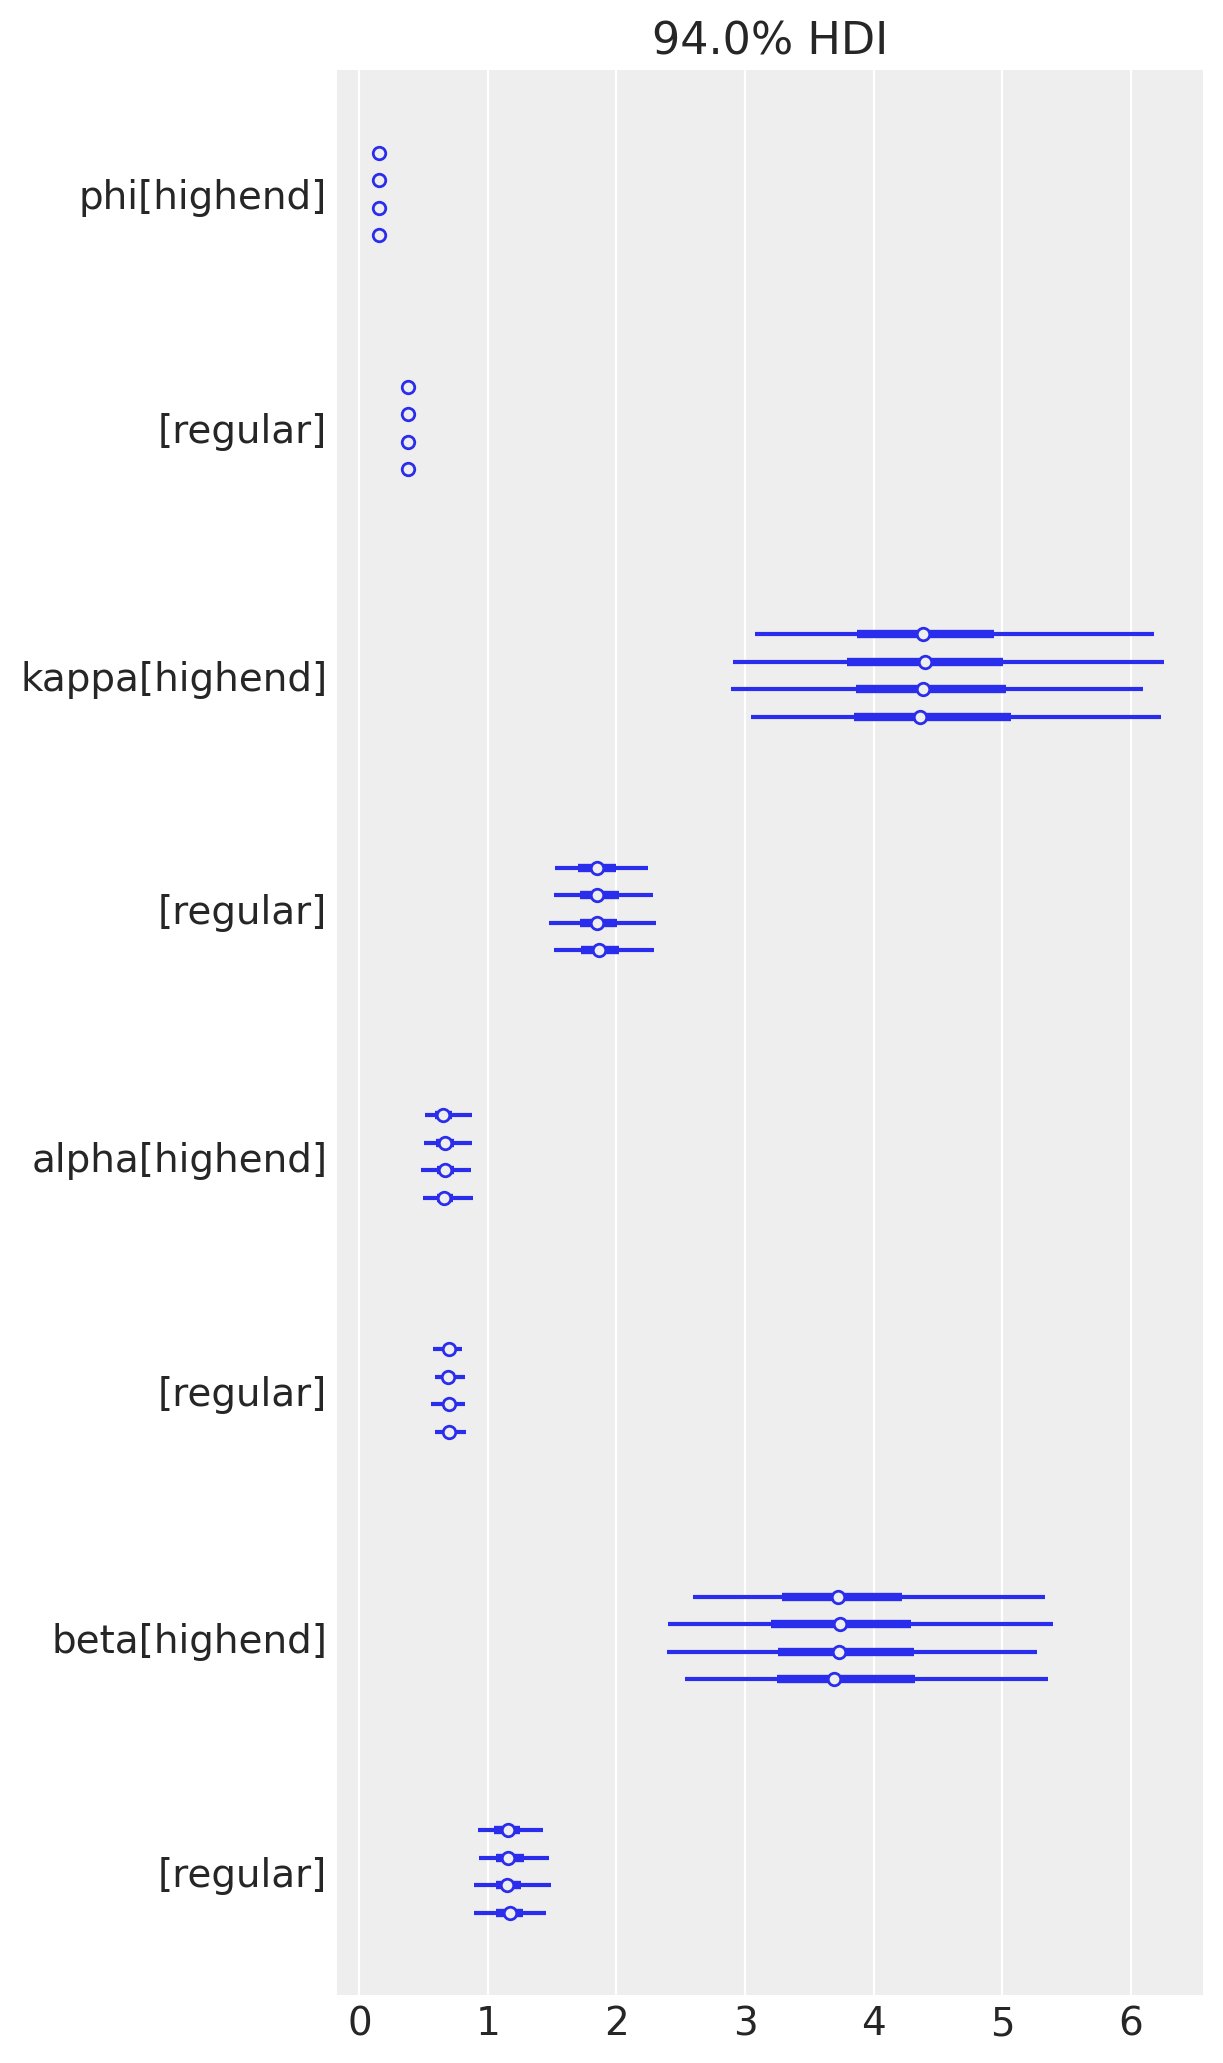

In [38]:
az.plot_forest(sbg.idata)

In [40]:
%load_ext watermark
%watermark -n -u -v -iv -w -p pymc,pytensor

Last updated: Wed Nov 05 2025

Python implementation: CPython
Python version       : 3.12.11
IPython version      : 9.4.0

pymc    : 5.25.1
pytensor: 2.31.7

pymc_extras   : 0.4.0
pytensor      : 2.31.7
pandas        : 2.3.1
pymc          : 5.25.1
arviz         : 0.22.0
matplotlib    : 3.10.3
numpy         : 2.2.6
pymc_marketing: 0.17.0
xarray        : 2025.7.1

Watermark: 2.5.0

